# Tests output ForecasterAutoregMultiseries (0.12.0)

In [15]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
import joblib

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
set_dark_theme()

# Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import ParameterGrid
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Others
# ==============================================================================
import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Auxiliar functions
# ==============================================================================
def series_long_format_to_dict(
    data: pd.DataFrame,
    series_id: str,
    index: str,
    values: str,
    freq: str,
):
    """
    Convert long format series to dictionary.

    Parameters
    ----------
    data: pd.DataFrame
        Long format series.
    series_id: str
        Column name with the series identifier.
    index: str
        Column name with the time index.
    values: str
        Column name with the values.
    freq: str
        Frequency of the series.

    Returns
    -------
    series_dict: dict
        Dictionary with the series.

    """

    series_dict = {}
    for k, v in data.groupby(series_id):
        series_dict[k] = v.set_index(index)[values].asfreq(freq).rename(k)

    return series_dict


def exog_long_format_to_dict(
    data: pd.DataFrame,
    series_id: str,
    index: str,
    freq: str
):
    """
    Convert long format exogenous variables to dictionary.

    Parameters
    ----------
    data: pd.DataFrame
        Long format exogenous variables.
    series_id: str
        Column name with the series identifier.
    index: str
        Column name with the time index.
    freq: str
        Frequency of the series.
    
    Returns
    -------
    exog_dict: dict
        Dictionary with the exogenous variables.

    """

    exog_dict =  dict(tuple(data.groupby(series_id)))
    exog_dict = {
        k: v.set_index(index).asfreq(freq).drop(columns=series_id)
        for k, v in exog_dict.items()
    }

    return exog_dict

# Test series of same length

In [17]:
# Load time series same length
# ==============================================================================
end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'

data  = pd.read_parquet('sample_building_consumption.parquet')
data = data.asfreq('D')
series = data[['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']]
exog  = data[['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']]

series_train = series.loc[: end_train, :].copy()
exog_train   = exog.loc[: end_train, :].copy()
series_val   = series.loc[end_train: end_validation, :].copy()
exog_val     = exog.loc[end_train: end_validation, :].copy()
series_test  = series.loc[end_validation:, :].copy()
exog_test    = exog.loc[end_validation:, :].copy()

series_dict = series.to_dict(orient='series')
exog_dict = {k: exog for k in series.columns}
series_dict_train = series_train.to_dict(orient='series')
exog_dict_train = {k: exog_train for k in series.columns}
series_dict_val = series_val.to_dict(orient='series')
exog_dict_val = {k: exog_val for k in series.columns}
series_dict_test = series_test.to_dict(orient='series')
exog_dict_test = {k: exog_test for k in series.columns}

In [18]:
# Test predictions
# ==============================================================================
steps = 10
forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series = StandardScaler()
)

forecaster.fit(series=series_train, exog=exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=exog_val)
predictions_1_interval = forecaster.predict_interval(
    steps=steps, exog=exog_val, interval=[5, 95], n_boot=50
)

forecaster.fit(series=series_train, exog=exog_dict_train)
predictions_2 = forecaster.predict(steps=steps, exog=exog_dict_val)
predictions_2_interval = forecaster.predict_interval(
    steps=steps, exog=exog_dict_val, interval=[5, 95], n_boot=50
)

forecaster.fit(series=series_dict_train, exog=exog_dict_train)
predictions_3 = forecaster.predict(steps=steps, exog=exog_dict_val)
predictions_3_interval = forecaster.predict_interval(
    steps=steps, exog=exog_dict_val, interval=[5, 95], n_boot=50
)

pd.testing.assert_frame_equal(predictions_1, predictions_2)
pd.testing.assert_frame_equal(predictions_1, predictions_3)
pd.testing.assert_frame_equal(predictions_1_interval, predictions_2_interval)
pd.testing.assert_frame_equal(predictions_1_interval, predictions_3_interval)

In [19]:
# Test backtesting
# ==============================================================================
params = {
    'refit' : [True, False, 2],
    'fixed_train_size': [True, False],
    'gap': [0, 7]
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")
        
    forecaster = ForecasterAutoregMultiSeries(
        regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler()
    )

    metrics_1, predictions_1 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog,
        levels                = None,
        steps                 = 24,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_2, predictions_2 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_3, predictions_3 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series_dict,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    pd.testing.assert_frame_equal(metrics_1, metrics_2)
    pd.testing.assert_frame_equal(predictions_1, predictions_2)
    pd.testing.assert_frame_equal(metrics_1, metrics_3)
    pd.testing.assert_frame_equal(predictions_1, predictions_3)
    print("   Test passed")


Paramns: {'fixed_train_size': True, 'gap': 0, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 0, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 0, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 0, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 7, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 7, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 7, 'refit': 2}
   Test passed


In [20]:
# Test backtesting with intervals
# ==============================================================================
params = {
    'refit' : [True, False, 2],
    'fixed_train_size': [True, False],
    'gap': [0, 7]
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")
        
    forecaster = ForecasterAutoregMultiSeries(
        regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler()
    )

    metrics_1, predictions_1 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog,
        levels                = None,
        steps                 = 24,
        interval              = [5, 95],
        n_boot                = 10,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_2, predictions_2 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        interval              = [5, 95],
        n_boot                = 10,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_3, predictions_3 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series_dict,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        interval              = [5, 95],
        n_boot                = 10,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    pd.testing.assert_frame_equal(metrics_1, metrics_2)
    pd.testing.assert_frame_equal(predictions_1, predictions_2)
    pd.testing.assert_frame_equal(metrics_1, metrics_3)
    pd.testing.assert_frame_equal(predictions_1, predictions_3)
    print("   Test passed")

Paramns: {'fixed_train_size': True, 'gap': 0, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 0, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 0, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 0, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 7, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 7, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': False, 'gap': 7, 'refit': 2}
   Test passed


In [21]:
# Test Bayesian search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

def search_space(trial):
    search_space  = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 25, 50, step=100),
        "max_depth": trial.suggest_int('max_depth', 2, 5),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning, module='optuna')

    results_search_1, best_trial_1 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series,
        exog               = exog,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )


    results_search_2, best_trial_2 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series,
        exog               = exog_dict,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )

    results_search_3, best_trial_3 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series_dict,
        exog               = exog_dict,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )

pd.testing.assert_frame_equal(results_search_1, results_search_2)
pd.testing.assert_frame_equal(results_search_1, results_search_3)

Number of models compared: 5,
         5 bayesian search in each lag configuration.
Number of models compared: 5,
         5 bayesian search in each lag configuration.
Number of models compared: 5,
         5 bayesian search in each lag configuration.


In [22]:
# Test Grid search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

param_grid = {
    "learning_rate": [0.1],
    "n_estimators": [10, 20],
    "max_depth": [2, 5],
}


results_search_1 = grid_search_forecaster_multiseries(
    forecaster         = forecaster,
    series             = series,
    exog               = exog,
    lags_grid          = lags_grid,
    param_grid         = param_grid,
    metric             = 'mean_absolute_error',
    initial_train_size = len(series_train),
    steps              = 10,
    refit              = False,
    return_best        = False,
    show_progress      = False,
    verbose            = False
)


results_search_2 = grid_search_forecaster_multiseries(
    forecaster         = forecaster,
    series             = series,
    exog               = exog_dict,
    lags_grid          = lags_grid,
    param_grid         = param_grid,
    metric             = 'mean_absolute_error',
    initial_train_size = len(series_train),
    steps              = 10,
    refit              = False,
    return_best        = False,
    show_progress      = False,
    verbose            = False
)

results_search_3 = grid_search_forecaster_multiseries(
    forecaster         = forecaster,
    series             = series_dict,
    exog               = exog_dict,
    lags_grid          = lags_grid,
    param_grid         = param_grid,
    metric             = 'mean_absolute_error',
    initial_train_size = len(series_train),
    steps              = 10,
    refit              = False,
    return_best        = False,
    show_progress      = False,
    verbose            = False
)

pd.testing.assert_frame_equal(results_search_1, results_search_2)
pd.testing.assert_frame_equal(results_search_1, results_search_3)

8 models compared for 5 level(s). Number of iterations: 8.
8 models compared for 5 level(s). Number of iterations: 8.
8 models compared for 5 level(s). Number of iterations: 8.


# Test series of different lengths

In [33]:
# Load time series of multiple lengths
# ==============================================================================
# series_dict = joblib.load('sample_multi_series.joblib')
# exog_dict = joblib.load('sample_multi_series_exog.joblib')

series = pd.read_csv('sample_multi_series.csv')
exog = pd.read_csv('sample_multi_series_exog.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])


series_dict = series_long_format_to_dict(
    data = series,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict = exog_long_format_to_dict(
    data = exog,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])

series_df = pd.DataFrame(series_dict)

In [34]:
# Partition data in train, validation and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'

series_df_train   = series_df.loc[: end_train, :].copy()
series_df_val     = series_df.loc[end_train:end_validation, :].copy()
series_df_test    = series_df.loc[end_validation:, :].copy()

series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_val   = {k: v.loc[end_train: end_validation] for k, v in series_dict.items()}
exog_dict_val     = {k: v.loc[end_train: end_validation,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_validation:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_validation:,] for k, v in exog_dict.items()}

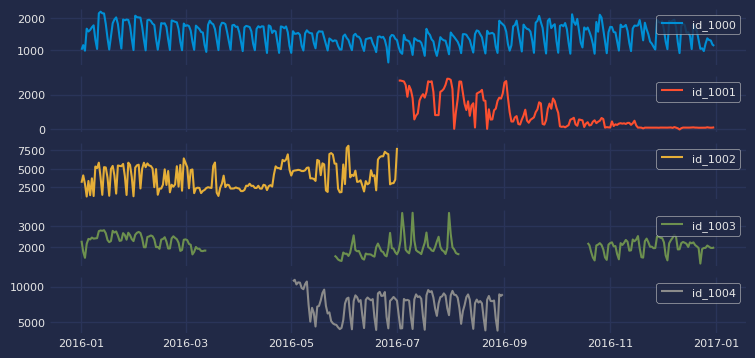

In [35]:
# Plot series
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [36]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"    Train: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"    Train: len=0")
    try:
        print(
            f"    Val  : len={len(series_dict_val[k])}, {series_dict_val[k].index[0]}"
            f" --- {series_dict_val[k].index[-1]}"
        )
    except:
        print(f"    Val  : len=0")
    try:
        print(
            f"    Test : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"    Test : len=0")

id_1000:
    Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
    Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
    Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
    Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
    Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
    Val  : len=0
    Test : len=0
id_1003:
    Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
    Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
    Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00
    Test : len=0


In [37]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"    {exog_dict[k].columns.to_list()}")
    except:
        print(f"    No exogenous variables")

id_1000:
    ['sin_day_of_week', 'cos_day_of_week']
id_1001:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


## Series is dataframe (filled with NaNs) and exog is dictionary

In [40]:
# Series is dataframe and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),            
            )
forecaster.fit(series=series_df_train, exog=exog_dict_train, suppress_warnings=True)
predictions_1 = forecaster.predict(steps=5, exog=exog_dict_val)
predictions_1

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:847: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:408: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


,id_1000,id_1001,id_1003,id_1004
2016-08-01,1394.276927,2392.921258,2511.194645,7603.716810
2016-08-02,1418.811542,2426.353956,2219.315130,7743.505865
2016-08-03,1419.502612,2335.709398,2123.562515,8175.269140
2016-08-04,1409.022008,2292.691635,2106.626013,8272.953203
2016-08-05,1373.139663,2222.711585,2128.060600,8117.061254


## Series is dictionary and exog is dictionary

In [45]:
# Series is dictionary and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),            
            )
forecaster.fit(series=series_dict_train, exog=exog_dict_train)
predictions_2 = forecaster.predict(steps=5, exog=exog_dict_val)
predictions_2

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:847: MissingExo

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1394.276927,2392.921258,2511.194645,7603.716810
2016-08-02,1418.811542,2426.353956,2219.315130,7743.505865
2016-08-03,1419.502612,2335.709398,2123.562515,8175.269140
2016-08-04,1409.022008,2292.691635,2106.626013,8272.953203
2016-08-05,1373.139663,2222.711585,2128.060600,8117.061254


In [46]:
pd.testing.assert_frame_equal(predictions_1, predictions_2)

## Backtesting

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


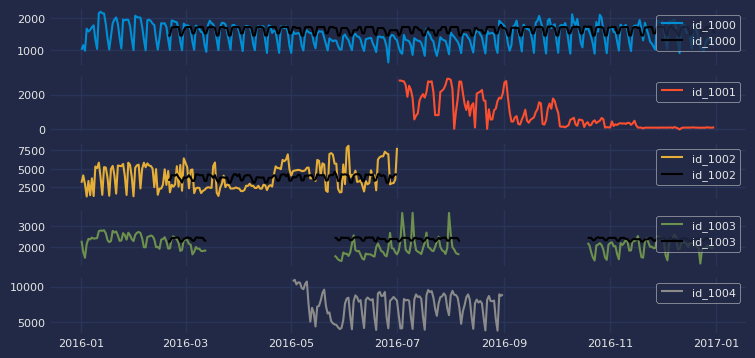

In [53]:
# Test backtesting
# ==============================================================================
params = {
    'refit' : False,
    'fixed_train_size': False,
    'gap': 0
}

forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler()
)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    levels                = None,
    steps                 = 24,
    metric                = ['mean_absolute_error', 'mean_squared_error'],
    initial_train_size    = 50,
    fixed_train_size      = params['fixed_train_size'],
    gap                   = params['gap'],
    allow_incomplete_fold = True,
    refit                 = params['refit'],
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = False
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

## Bayesian Search

In [48]:
series_dict['id_1002'].at['2016-02-01'] = np.nan
series_dict['id_1002'].at['2016-05-01'] = np.nan

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:767: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:767: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarni

Backtest metrics


,levels,mean_absolute_error,mean_squared_error
0,id_1000,190.673434,6.024335e+04
1,id_1001,472.346257,4.301278e+05
2,id_1002,1601.410583,4.001583e+06
3,id_1003,346.856873,2.363924e+05
4,id_1004,1025.527032,1.719722e+06



Backtest predictions


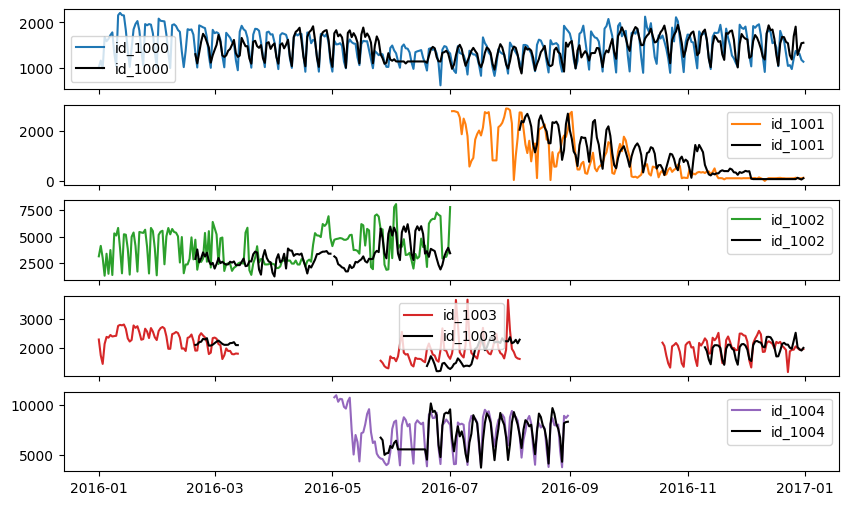

In [51]:
# import warnings
# from skforecast.exceptions import MissingValuesWarning
# warnings.simplefilter('ignore', category=MissingValuesWarning)

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series= False
            )

# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = series_dict,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = ['mean_absolute_error', 'mean_squared_error'],
                                           initial_train_size    = 50,
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = True,
                                           n_jobs                = 1,
                                           verbose               = False,
                                           show_progress         = True,
                                           suppress_warnings=False
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series.columns):
    axs[i].plot(series[s], label=series[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend()

In [43]:
series_dict['id_1002'].at['2016-02-01'] = 1000

series_dict['id_1002'].at['2016-05-01'] = 2000

In [44]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series= True
            )
forecaster.fit(series=series_dict, suppress_warnings=True)

In [45]:
forecaster.series_col_names

['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']

  0%|          | 0/15 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error
0,id_1000,97.325226,2.018969e+04
1,id_1001,261.702238,1.628551e+05
2,id_1002,1002.471695,1.720915e+06
3,id_1003,148.822789,4.702778e+04
4,id_1004,580.297714,6.570378e+05



Backtest predictions


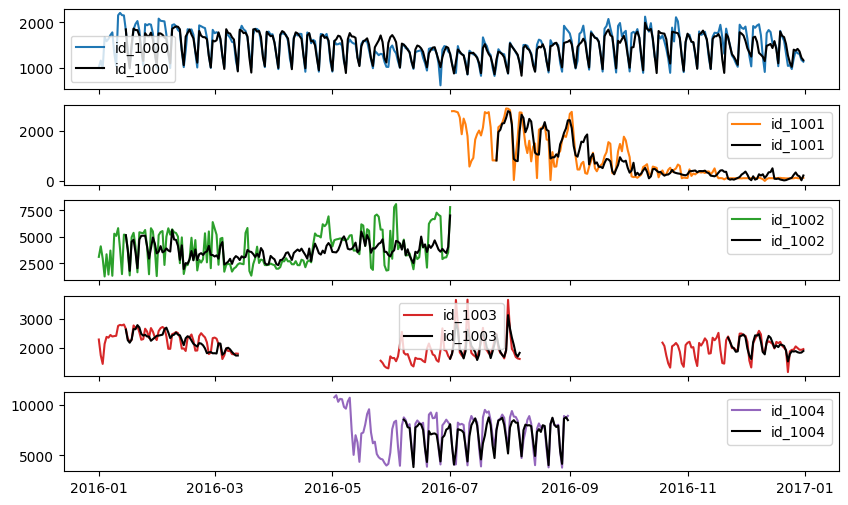

In [46]:
# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = series_dict,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = ['mean_absolute_error', 'mean_squared_error'],
                                           initial_train_size    = None,
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           n_jobs                = 1,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series.columns):
    axs[i].plot(series[s], label=series[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend()

# Puntos a revisar

+ ¿Exog en el predict tiene que ser necesariamente un dataframe? Ahora mismo hay conflicto de tipos. Predict espera un exog del mismo tipo que en train, pero tiene un check que en predict solo permite dataframe o serie. Si el forecaster se entrena con dict falla.

In [25]:
levels_in_backtest_predictions = [
    'l1', 'l1_lower_bound', 'l1_upper_bound',
    'l2', 'l2_lower_bound', 'l2_upper_bound',
    'l3', 'l3_lower_bound', 'l3_upper_bound',
]
levels_in_backtest_predictions

['l1',
 'l1_lower_bound',
 'l1_upper_bound',
 'l2',
 'l2_lower_bound',
 'l2_upper_bound',
 'l3',
 'l3_lower_bound',
 'l3_upper_bound']

In [26]:
import re

levels_in_backtest_predictions = [
    level 
    for level in levels_in_backtest_predictions
    if not re.search(r'_lower_bound|_upper_bound', level)
]
levels_in_backtest_predictions

['l1', 'l2', 'l3']

'l1'